In [50]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

In [ ]:
#Preparation, already finished

df_org = pd.read_excel('FinalVersion.xlsx')
snapshot = pd.read_excel('fund_snapshot_lux.xlsx')

cols = ['FundId', 'Month', 'Fund Size', 'Fund Flow', 'Fund Sustainability', 'CAPM Performance', 'Performance Three Factor', 'Performance Four Factor']
df = df_org[cols].replace({0:np.nan})

cols_snapshot = ['FundId', 'Inception Date', 'Equity Style Box (Long)']
snap = snapshot[cols_snapshot].replace({0:np.nan})

In [ ]:
#snap join into the summary, the ages are calculated according to the inception date
joint = df.join(snap.set_index('FundId'), on='FundId')
age = (joint['Inception Date'] - pd.to_datetime(2019-8-1))/np.timedelta64(1,'M')
joint['Age'] = age

fund_size_log = np.log10(joint['Fund Size'])
joint['size_log'] = fund_size_log

#the joint is saved and the column name Fund Sustainability is changed because of the space
#joint.to_excel("joint_snap.xlsx") 

In [8]:
joint = pd.read_excel('joint_snap.xlsx')

In [3]:
#convert the month column into correct form
joint['Month'] = pd.to_datetime(joint['Month'])
age = (joint['Month'] - joint['Inception Date'])/np.timedelta64(1,'M')
age = [int(i) for i in age]
joint['Age'] = age
#joint.dropna(subset=["esg_score"], inplace=True)

#convert the esb_l from string to float
esb_l = pd.DataFrame({'Equity Style Box (Long)':['Large Value', 'Large Growth', 'Large Blend', 'Mid Value', 'Mid Growth', 'Mid Blend','Small Value','Small Growth','Small Blend'], 'esb_l': [1, 2, 3, 4, 5, 6, 7, 8, 9]})
joint_new = joint.join(esb_l.set_index('Equity Style Box (Long)'), on='Equity Style Box (Long)')

#relative_flow is the size divided by flow value
flow = joint_new["Fund Flow"]
size = joint_new['Fund Size']
relative_flow = flow/size
joint_new['relative_flow'] = relative_flow

joint_new = joint_new.rename(columns={"Fund Sustainability": "esg_score"})

In [110]:
#calculate the vif
X = joint_new[['esg_score','Age','size_log']].dropna()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

,VIF Factor,features
0,58.160414,esg_score
1,3.050088,Age
2,62.220287,size_log


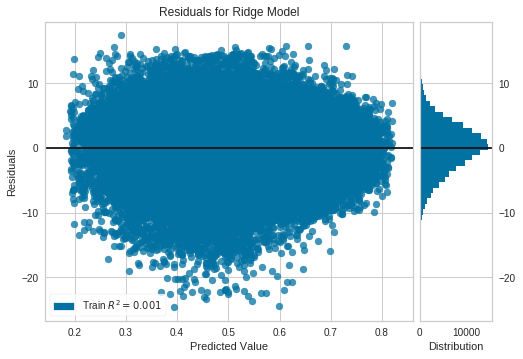

In [117]:
#residual with train and data set
data = joint_new[['esg_score','Age','size_log','capm_Performance']].dropna()

X = data[['esg_score','Age','size_log']]
y = data['capm_Performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)
model = Ridge()

visualizer = ResidualsPlot(model)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
 
#visualizer.show()                 # Finalize and render the figure

visualizer.show(outpath="Residual.pdf")

In [43]:
#catagorize the month - 2012/01 to 2019/08, totoally 92 months
month = pd.Categorical(joint_new.Month)

#use the 'Month' to divide the dataset, the index is Fund ID
df = joint_new.set_index(['FundId', 'Month'])
df['Month'] = month

In [44]:
#xtreg In_wage age 
exog_vars = ['esg_score','size_log', 'Age', 'relative_flow']
exog = sm.add_constant(df[exog_vars])

/home/yuxuan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [45]:
exog

const  esg_score  size_log  Age  relative_flow
FundId     Month                                                     
FS00008SZD 2012-01-01    1.0        NaN  8.416574   35       0.167821
           2012-02-01    1.0        NaN  8.475439   36       0.086092
           2012-03-01    1.0        NaN  8.487284   37       0.005074
           2012-04-01    1.0        NaN  8.536653   38       0.109079
           2012-05-01    1.0        NaN  8.576478   39       0.129341
...                      ...        ...       ...  ...            ...
FSUSA09WNF 2019-04-01    1.0        NaN  6.910505  124      -0.000183
           2019-05-01    1.0        NaN  6.901951  125       0.000101
           2019-06-01    1.0      40.91  6.937071  126       0.000238
           2019-07-01    1.0        NaN  6.941370  127      -0.000259
           2019-08-01    1.0        NaN  6.916760  128       0.000258

[301392 rows x 5 columns]

In [46]:
mod = PanelOLS(df.capm_Performance, exog, entity_effects=True, time_effects=True)
mod

/home/yuxuan/anaconda3/lib/python3.7/site-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


PanelOLS 
Num exog: 5, Constant: True
Entity Effects: True, Time Effects: True, Num Other Effects: 0
id: 0x7f8a23453150

In [47]:
res = mod.fit()
res2 = mod.fit(cov_type='clustered', cluster_entity=True)

In [48]:
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       capm_Performance   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):             -0.1504
No. Observations:              155105   R-squared (Within):               0.0003
Date:                Sun, Apr 05 2020   R-squared (Overall):             -0.0072
Time:                        20:52:47   Log-likelihood                -3.503e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      32.999
Entities:                        3261   P-value                           0.0000
Avg Obs:                       47.564   Distribution:                F(4,151750)
Min Obs:                       1.0000                                           
Max Obs:                       91.000   F-statistic (robust):             32.999
                            

In [ ]:
x2 = np.linspace(38, 60, 3276*92)
y2 = [0.02*ix - 0.4699 for ix in x2]
plt.cla()
plt.plot(df['Fund Sustainability'][1000:2000], df['capm_Performance'][1000:2000], ".r")
plt.plot(x2, y2, "-b")
plt.grid(True)
plt.title("Factor Loading First Month: 2012-01")
plt.xlabel("beta_value")
plt.ylabel("Fund Return of All Month")
plt.pause(.5)


In [ ]:
#example
data = pd.read_stata('nlswork.dta')
year = pd.Categorical(data.year)
data = data.set_index(['idcode','year'])
data['year']=year

exog_vars = ['age','tenure','south']
exog = sm.add_constant(data[exog_vars])

mod = PanelOLS(data.ln_wage, exog, entity_effects=True)

res = mod.fit()

res2 = mod.fit(cov_type='clustered', cluster_entity=True)

exog_vars2 = ['age','tenure','south', 'year']
exog2 = sm.add_constant(data[exog_vars2])

mod2 = PanelOLS(data.ln_wage, exog2, entity_effects=True)

res3 = mod2.fit(cov_type='clustered', cluster_entity=True)